In [1]:
import pandas as pd
import collections
from collections import Counter
import string
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
df_all = pd.read_csv('surnames_with_splits.csv')
print("shape of the data: ", df_all.shape)
print('-'*60)
print(df_all.head())

shape of the data:  (10980, 4)
------------------------------------------------------------
  nationality  nationality_index  split   surname
0      Arabic                 15  train     Totah
1      Arabic                 15  train    Abboud
2      Arabic                 15  train  Fakhoury
3      Arabic                 15  train     Srour
4      Arabic                 15  train    Sayegh


# Define two relevent classes
### - Vocabulary ([see a walkthrough here](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/class_Vocabulary.ipynb))
### - SurnameVectorizer ([see a walkthrough here](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/class_Vectorizer.ipynb))

In [3]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk   = add_unk
        self._unk_token = unk_token      
        self.unk_index  = -999
        ### the unk_token, i.e, "<UNK>" is the first added token if add_unk=True
        ### self.unk_index is changed from -999 to 0
        if add_unk:
            self.unk_index = self.add_token(unk_token) 

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
   
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            ### .get(): return self.unk_index if the key "token" does not exist. 
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]
    
    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    
    def __len__(self):
        return len(self._token_to_idx)

    
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab
         
    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab     = Vocabulary(add_unk=True, unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)
        
        ########## Add tokens to surname_vocab and nationality_vocab
        for index, row in surname_df.iterrows():
            # Add tokens(characters) to surname_vocab
            for letter in row.surname:
                surname_vocab.add_token(letter)
            # Add tokens(words) to nationality_vocab
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab)

    ### This is the key functionality of the Vectorizer.
    ### It takes as an argument a string representing a surname,
    ### and returns a vectorized representation of the surname.
    def vectorize(self, surname):
        """
        Create a collapsed one-hot representation vector for the surname
        Limitations of the one-hot method:
        1 - Sparseness, n_unique_characters in a surname << n_unique_characters in a vocabulary
        2 - Discarding the order of the words' appearance
        
        Args:
            surname (str): the surname 
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding 
        """
        ### Create an array where each element corresponds to each character in the vocabulary
        one_hot = np.zeros(len(self.surname_vocab), dtype=np.float32)
        ### Run lookup_token() for each character in the surname sequentially, return an index
        ### Assign the corresponding element in the array to 1.
        for token in surname:
            one_hot[self.surname_vocab.lookup_token(token)] = 1
        return one_hot

# 1. SurnameDataset class
### - The Dataset class will characterize the key features of the dataset.
### - In the initialization function of the class, make the class inherit the properties of torch.utils.data.Dataset so that we can later leverage its functionalities.
### - In the \_\_init\_\_() function and the set_split() function, store important information such as labels and the features that we wish to generate at each pass.
### - Each call requests a sample index for which the upperbound is specified in the \_\_len\_\_() method.
### - When the sample corresponding to a given index is called, the generator executes the \_\_getitem\_\_() method to generate it.

In [4]:
class SurnameDataset(Dataset):
    def __init__(self,surname_df,vectorizer):
        self.surname_df  = surname_df
        self._vectorizer = vectorizer
        
        self.train_df    = self.surname_df[self.surname_df.split=='train']
        self.train_size  = len(self.train_df)

        self.val_df      = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df     = self.surname_df[self.surname_df.split=='test']
        self.test_size   = len(self.test_df)
        
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val'  : (self.val_df, self.validation_size),
                             'test' : (self.test_df, self.test_size)}
        self.set_split('train')
        
        # Class weights - Assign a weight to each class that inversely proportional to its frequency.
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
    @classmethod
    def load_csv_and_make_vectorizer(cls,surname_csv):
        """Load dataset and make a new vectorizer from scratch
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        ### make vectorizer using training dataset
        train_surname_df = surname_df[surname_df.split=='train']
        new_vectorizer  = SurnameVectorizer.from_dataframe(train_surname_df)
        return cls(surname_df,new_vectorizer)
    
    @classmethod
    def load_df_and_make_vectorizer(cls,surname_df):
        """Load dataset and make a new vectorizer from scratch
        Args:
            surname_df: dataset
        Returns:
            an instance of SurnameDataset
        """
        ### make vectorizer using training dataset
        train_surname_df = surname_df[surname_df.split=='train']
        new_vectorizer  = SurnameVectorizer.from_dataframe(train_surname_df)
        return cls(surname_df,new_vectorizer)
    
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        ### when split = 'train', _target_df means the training set
        self._target_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        ### _target_size is defined in set_split() 
        return self._target_size        
        
    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        
        row = self._target_df.iloc[index]

        surname_vector = \
            self._vectorizer.vectorize(row.surname)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector,
                'y_target': nationality_index}

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
    
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  

# 2. Instantiate a SurnameDataset from the training data
### There are two classmethods can be used to instantiate a SurnameDataset: load_csv_and_make_vectorizer() and load_df_and_make_vectorizer(). The difference is whether the input data is from a csv file or a pd.DataFrame file. 

### First draw a (static, fixed random seed) from the entire datas

In [5]:
df_sample = df_all.sample(100,random_state=100)

In [6]:
df_sample.head()

,nationality,nationality_index,split,surname
5362,English,12,test,Hepples
900,Arabic,15,train,Sarkis
10686,Spanish,6,train,Garza
8902,Russian,13,train,Zhurikhin
1296,Arabic,15,val,Aswad


In [7]:
pd.crosstab(df_sample['nationality'], df_sample['split'])

split,test,train,val
nationality,,,
Arabic,3,12,2
Chinese,1,2,0
Czech,1,2,0
English,4,18,1
French,0,2,0
German,1,4,1
Irish,0,3,0
Italian,2,5,1
Japanese,2,4,3


### Create a SurnameDataset.

In [8]:
dataset_sample = SurnameDataset.load_df_and_make_vectorizer(df_sample)

## 2.1 - Attributes of a SurnameDataset

### .surname_df: the input dataframe

In [9]:
dataset_sample.surname_df

,nationality,nationality_index,split,surname
5362,English,12,test,Hepples
900,Arabic,15,train,Sarkis
10686,Spanish,6,train,Garza
8902,Russian,13,train,Zhurikhin
1296,Arabic,15,val,Aswad
...,...,...,...,...
2083,Czech,5,train,Oborny
6192,German,9,test,Bader
6784,Italian,17,train,De
9666,Russian,13,train,Harash


In [10]:
dataset_sample.surname_df.equals(df_sample)

True

### ._vectorizer

In [11]:
### Note that the vectorizer is derived from the training split. 
v = dataset_sample._vectorizer

In [12]:
example_text = "Smith"
one_hot      = v.vectorize(example_text)

In [13]:
print(f'Surname Vocabulary')
print('-'*60)
print("_idx_to_token: ", v.surname_vocab._idx_to_token)
print('-'*60)
print('One-hot representation:', one_hot)

Surname Vocabulary
------------------------------------------------------------
_idx_to_token:  {0: '@', 1: 'S', 2: 'a', 3: 'r', 4: 'k', 5: 'i', 6: 's', 7: 'G', 8: 'z', 9: 'Z', 10: 'h', 11: 'u', 12: 'n', 13: 'A', 14: 'w', 15: 'e', 16: 't', 17: 'c', 18: 'H', 19: 'v', 20: 'o', 21: 'g', 22: 'b', 23: 'y', 24: 'Y', 25: 'm', 26: 'V', 27: 'l', 28: 'D', 29: 'N', 30: 'T', 31: 'C', 32: 'd', 33: 'J', 34: 'p', 35: 'K', 36: 'M', 37: 'L', 38: 'j', 39: 'W', 40: 'B', 41: 'P', 42: 'q', 43: 'F', 44: 'è', 45: 'f', 46: 'R', 47: 'O'}
------------------------------------------------------------
One-hot representation: [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### ._target_df, _target_size
**Defined by method set_split()**

In [14]:
dataset_sample._target_df

,nationality,nationality_index,split,surname
900,Arabic,15,train,Sarkis
10686,Spanish,6,train,Garza
8902,Russian,13,train,Zhurikhin
9241,Russian,13,train,Aweritchkin
8707,Russian,13,train,Hatskevich
...,...,...,...,...
2662,English,12,train,Rogerson
2083,Czech,5,train,Oborny
6784,Italian,17,train,De
9666,Russian,13,train,Harash


In [15]:
dataset_sample._target_size

70

### ._lookup_dict - will be used in the method set_split()

In [16]:
dataset_sample._lookup_dict

{'train': (      nationality  nationality_index  split      surname
  900        Arabic                 15  train       Sarkis
  10686     Spanish                  6  train        Garza
  8902      Russian                 13  train    Zhurikhin
  9241      Russian                 13  train  Aweritchkin
  8707      Russian                 13  train   Hatskevich
  ...           ...                ...    ...          ...
  2662      English                 12  train     Rogerson
  2083        Czech                  5  train       Oborny
  6784      Italian                 17  train           De
  9666      Russian                 13  train       Harash
  10722     Spanish                  6  train       Ybarra
  
  [70 rows x 4 columns],
  70),
 'val': (      nationality  nationality_index split    surname
  1296       Arabic                 15   val      Aswad
  9991      Russian                 13   val  Lebedenko
  4807      English                 12   val      Vinny
  7831     Japane

In [17]:
### A dictionary which contains a df and a scalar
dataset_sample._lookup_dict['train']

(      nationality  nationality_index  split      surname
 900        Arabic                 15  train       Sarkis
 10686     Spanish                  6  train        Garza
 8902      Russian                 13  train    Zhurikhin
 9241      Russian                 13  train  Aweritchkin
 8707      Russian                 13  train   Hatskevich
 ...           ...                ...    ...          ...
 2662      English                 12  train     Rogerson
 2083        Czech                  5  train       Oborny
 6784      Italian                 17  train           De
 9666      Russian                 13  train       Harash
 10722     Spanish                  6  train       Ybarra
 
 [70 rows x 4 columns],
 70)

In [18]:
### the dataframe
dataset_sample._lookup_dict['train'][0]

,nationality,nationality_index,split,surname
900,Arabic,15,train,Sarkis
10686,Spanish,6,train,Garza
8902,Russian,13,train,Zhurikhin
9241,Russian,13,train,Aweritchkin
8707,Russian,13,train,Hatskevich
...,...,...,...,...
2662,English,12,train,Rogerson
2083,Czech,5,train,Oborny
6784,Italian,17,train,De
9666,Russian,13,train,Harash


In [19]:
### the sample size
dataset_sample._lookup_dict['train'][1]

70

### .class_weights
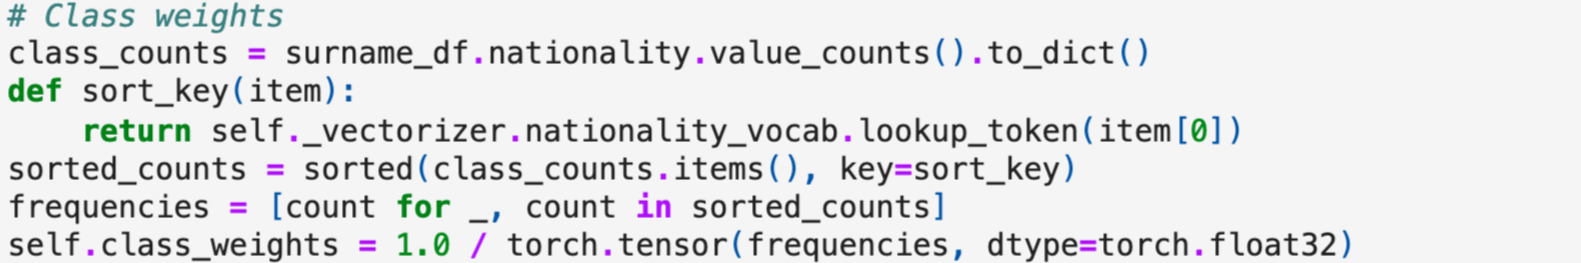

In [20]:
print('The order of nationality labels in dataset_sample._vectorizer.nationality_vocab')
dataset_sample._vectorizer.nationality_vocab._token_to_idx

The order of nationality labels in dataset_sample._vectorizer.nationality_vocab


{'Arabic': 0,
 'Spanish': 1,
 'Russian': 2,
 'English': 3,
 'Japanese': 4,
 'Chinese': 5,
 'German': 6,
 'Irish': 7,
 'Polish': 8,
 'Korean': 9,
 'French': 10,
 'Italian': 11,
 'Czech': 12}

In [21]:
class_counts = df_sample.nationality.value_counts().to_dict()
print("class_counts")
class_counts

class_counts


{'English': 23,
 'Russian': 19,
 'Arabic': 17,
 'Japanese': 9,
 'Italian': 8,
 'German': 6,
 'Spanish': 4,
 'Chinese': 3,
 'Irish': 3,
 'Czech': 3,
 'Polish': 2,
 'French': 2,
 'Korean': 1}

In [22]:
def sort_key(item):
    return dataset_sample._vectorizer.nationality_vocab.lookup_token(item[0])
sorted_counts = sorted(class_counts.items(), key=sort_key)
print('class_counts, sorted by the order in dataset_sample._vectorizer.nationality_vocab._token_to_idx)')
sorted_counts

class_counts, sorted by the order in dataset_sample._vectorizer.nationality_vocab._token_to_idx)


[('Arabic', 17),
 ('Spanish', 4),
 ('Russian', 19),
 ('English', 23),
 ('Japanese', 9),
 ('Chinese', 3),
 ('German', 6),
 ('Irish', 3),
 ('Polish', 2),
 ('Korean', 1),
 ('French', 2),
 ('Italian', 8),
 ('Czech', 3)]

In [23]:
print("class_counts.items()")
print(class_counts.items())
print('-'*60)
print("list(class_counts.items())")
print(list(class_counts.items()))
print('-'*60)
print("One element in list(class_counts.items())")
print(list(class_counts.items())[0])
print('-'*60)
print("item[0] in self._vectorizer.nationality_vocab.lookup_token(item[0]) as 'key' in sorted")
list(class_counts.items())[0][0]

class_counts.items()
dict_items([('English', 23), ('Russian', 19), ('Arabic', 17), ('Japanese', 9), ('Italian', 8), ('German', 6), ('Spanish', 4), ('Chinese', 3), ('Irish', 3), ('Czech', 3), ('Polish', 2), ('French', 2), ('Korean', 1)])
------------------------------------------------------------
list(class_counts.items())
[('English', 23), ('Russian', 19), ('Arabic', 17), ('Japanese', 9), ('Italian', 8), ('German', 6), ('Spanish', 4), ('Chinese', 3), ('Irish', 3), ('Czech', 3), ('Polish', 2), ('French', 2), ('Korean', 1)]
------------------------------------------------------------
One element in list(class_counts.items())
('English', 23)
------------------------------------------------------------
item[0] in self._vectorizer.nationality_vocab.lookup_token(item[0]) as 'key' in sorted


'English'

In [24]:
### The index of "English" in nationality_vocab is 3
### so "English" is the fourth in the sorted class_counts
print('English')
print(dataset_sample._vectorizer.nationality_vocab.lookup_token('English'))
print('-'*60)
print('Japanese')
print(dataset_sample._vectorizer.nationality_vocab.lookup_token('Japanese'))
print('-'*60)
print('Italian')
print(dataset_sample._vectorizer.nationality_vocab.lookup_token('Italian'))
print('-'*60)
sorted_counts

English
3
------------------------------------------------------------
Japanese
4
------------------------------------------------------------
Italian
11
------------------------------------------------------------


[('Arabic', 17),
 ('Spanish', 4),
 ('Russian', 19),
 ('English', 23),
 ('Japanese', 9),
 ('Chinese', 3),
 ('German', 6),
 ('Irish', 3),
 ('Polish', 2),
 ('Korean', 1),
 ('French', 2),
 ('Italian', 8),
 ('Czech', 3)]

In [25]:
frequencies = [count for _, count in sorted_counts]
print("frequencies")
print(frequencies)
print('-'*80)
print("weights = 1/frequencies")
1.0 / torch.tensor(frequencies, dtype=torch.float32)

frequencies
[17, 4, 19, 23, 9, 3, 6, 3, 2, 1, 2, 8, 3]
--------------------------------------------------------------------------------
weights = 1/frequencies


tensor([0.0588, 0.2500, 0.0526, 0.0435, 0.1111, 0.3333, 0.1667, 0.3333, 0.5000,
        1.0000, 0.5000, 0.1250, 0.3333])

## 2.2 - Methods of a SurnameDataset

### \_\_len()\_\_

In [26]:
len(dataset_sample)

70

### \_\_getitem()\_\_

In [27]:
### The 4th element in the "train" split
### In the __init__ function, self.set_split('train') defines ._target_df
dataset_sample[3]

{'x_data': array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'y_target': 2}

In [28]:
df_sample.head(5)

,nationality,nationality_index,split,surname
5362,English,12,test,Hepples
900,Arabic,15,train,Sarkis
10686,Spanish,6,train,Garza
8902,Russian,13,train,Zhurikhin
1296,Arabic,15,val,Aswad


### set_split()

In [29]:
dataset_sample = SurnameDataset.load_df_and_make_vectorizer(df_sample)

In [30]:
### Now the split for ._target_df and _target_size is 'train'
dataset_sample._target_df

,nationality,nationality_index,split,surname
900,Arabic,15,train,Sarkis
10686,Spanish,6,train,Garza
8902,Russian,13,train,Zhurikhin
9241,Russian,13,train,Aweritchkin
8707,Russian,13,train,Hatskevich
...,...,...,...,...
2662,English,12,train,Rogerson
2083,Czech,5,train,Oborny
6784,Italian,17,train,De
9666,Russian,13,train,Harash


In [31]:
len(dataset_sample)

70

In [32]:
dataset_sample[3]

{'x_data': array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'y_target': 2}

In [33]:
### run set_split, switch the split to 'val'
dataset_sample.set_split('val')
# or 
# SurnameDataset.set_split(dataset_sample,'val')

In [34]:
### Now the split for ._target_df and _target_size is 'val'
dataset_sample._target_df

,nationality,nationality_index,split,surname
1296,Arabic,15,val,Aswad
9991,Russian,13,val,Lebedenko
4807,English,12,val,Vinny
7831,Japanese,7,val,Toyoshima
7037,Italian,17,val,Amadori
6105,German,9,val,Brose
7819,Japanese,7,val,Okada
7786,Japanese,7,val,Funakoshi
10178,Russian,13,val,Gudarenko
1283,Arabic,15,val,Seif


In [35]:
len(dataset_sample)

10

In [36]:
dataset_sample[3]

{'x_data': array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'y_target': 4}

### get_vectorizer()

In [37]:
dataset_sample.get_vectorizer()

In [38]:
### Equivalently
dataset_sample._vectorizer

### get_num_batches()

In [39]:
dataset_sample.get_num_batches(10)

1

In [40]:
len(dataset_sample._target_df)/10

1.0

In [41]:
len(dataset_sample)/10

1.0

In [42]:
### Switch the split to 'train'
dataset_sample.set_split('train')

In [43]:
dataset_sample.get_num_batches(10)

7

In [44]:
len(dataset_sample._target_df)/10

7.0

In [45]:
len(dataset_sample._target_df)//10

7

# 3. Define a batch generator
### - Wrap the DataLoader
### - Switch the data between the CPU and the GPU.

In [46]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device='cpu'):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## 3.1 Dataset Class
### - The Dataset class characterizes the key features of the dataset you want to generate.
### - The class uses \_\_init\_\_(), \_\_len\_\_(), and \_\_getitem\_\_() to store important information, and generate samples. 
### - The Dataset class is an important argument of the DataLoader class.

In [47]:
data = {'x1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'x2': [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
        'y': [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0]}
data
df = pd.DataFrame(data)
print("data:" ,data)
print("-"*60)
print("df:",df)

data: {'x1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'x2': [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'y': [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0]}
------------------------------------------------------------
df:     x1  x2  y
0    1  13  0
1    2  14  1
2    3  15  0
3    4  16  1
4    5  17  1
5    6  18  0
6    7  19  0
7    8  20  1
8    9  21  1
9   10  22  0
10  11  23  1
11  12  24  0


In [48]:
##### Define Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = torch.tensor(self.data.iloc[index, :-1].values, dtype=torch.float32)
        target = torch.tensor(self.data.iloc[index, -1], dtype=torch.float32)
        return sample, target

##### Instantiate the Dataset class
custom_dataset = CustomDataset(df)

##### Instantiate the DataLoader class
batch_size  = 3
data_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=False)

##### Obtain the batch
i = 0
for batch in data_loader:
    print('Batch '+str(i))
    i+=1
    print(batch)
    print('-' * 60)

Batch 0
[tensor([[ 1., 13.],
        [ 2., 14.],
        [ 3., 15.]]), tensor([0., 1., 0.])]
------------------------------------------------------------
Batch 1
[tensor([[ 4., 16.],
        [ 5., 17.],
        [ 6., 18.]]), tensor([1., 1., 0.])]
------------------------------------------------------------
Batch 2
[tensor([[ 7., 19.],
        [ 8., 20.],
        [ 9., 21.]]), tensor([0., 1., 1.])]
------------------------------------------------------------
Batch 3
[tensor([[10., 22.],
        [11., 23.],
        [12., 24.]]), tensor([0., 1., 0.])]
------------------------------------------------------------


### An alternative is to use TensorDataset() directly

In [49]:
from torch.utils.data import TensorDataset

In [50]:
x1 = torch.from_numpy(df['x1'].values).float()
x2 = torch.from_numpy(df['x2'].values).float()
y  = torch.from_numpy(df['y'].values).float()
print("x1:", x1)
print("x2:", x2)
print("y:", y)

x1: tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
x2: tensor([13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])
y: tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0.])


In [51]:
features = torch.stack([x1, x2], dim=1)
features

tensor([[ 1., 13.],
        [ 2., 14.],
        [ 3., 15.],
        [ 4., 16.],
        [ 5., 17.],
        [ 6., 18.],
        [ 7., 19.],
        [ 8., 20.],
        [ 9., 21.],
        [10., 22.],
        [11., 23.],
        [12., 24.]])

In [52]:
##### Create Tensor dataset
dataset     = TensorDataset(features, y)
batch_size  = 3

##### Instantiate the DataLoader class
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

##### Obtain the batch
i = 0
for batch in data_loader:
    print('Batch '+str(i))
    i+=1
    print(batch)
    print('-' * 60)

Batch 0
[tensor([[ 1., 13.],
        [ 2., 14.],
        [ 3., 15.]]), tensor([0., 1., 0.])]
------------------------------------------------------------
Batch 1
[tensor([[ 4., 16.],
        [ 5., 17.],
        [ 6., 18.]]), tensor([1., 1., 0.])]
------------------------------------------------------------
Batch 2
[tensor([[ 7., 19.],
        [ 8., 20.],
        [ 9., 21.]]), tensor([0., 1., 1.])]
------------------------------------------------------------
Batch 3
[tensor([[10., 22.],
        [11., 23.],
        [12., 24.]]), tensor([0., 1., 0.])]
------------------------------------------------------------


### The two methods below are equivalent

In [53]:
x1 = torch.from_numpy(df['x1'].values).float()
x2 = torch.from_numpy(df['x2'].values).float()
torch.stack([x1, x2], dim=1)

tensor([[ 1., 13.],
        [ 2., 14.],
        [ 3., 15.],
        [ 4., 16.],
        [ 5., 17.],
        [ 6., 18.],
        [ 7., 19.],
        [ 8., 20.],
        [ 9., 21.],
        [10., 22.],
        [11., 23.],
        [12., 24.]])

In [54]:
numpy_array = df[['x1', 'x2']].to_numpy()
torch.from_numpy(numpy_array)

tensor([[ 1, 13],
        [ 2, 14],
        [ 3, 15],
        [ 4, 16],
        [ 5, 17],
        [ 6, 18],
        [ 7, 19],
        [ 8, 20],
        [ 9, 21],
        [10, 22],
        [11, 23],
        [12, 24]])

## 3.2 DataLoader
### - batch_size: denotes the number of samples contained in each generated batch.
### - shuffle: if set to True, we will get a new order of exploration at each pass (or just keep a linear exploration scheme otherwise). Shuffling the order in which examples are fed to the classifier is helpful so that batches between epochs do not look alike. Doing so will eventually make our model more robust.
### - drop_last: set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)

In [55]:
type(dataset_sample[0]['x_data'])

numpy.ndarray

In [56]:
dataset_sample = SurnameDataset.load_df_and_make_vectorizer(df_sample)
batch_size     = 10
shuffle        = True
drop_last      = True
dataloader     = DataLoader(dataset=dataset_sample, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

In [57]:
one_batch = next(iter(dataloader))
print('x in one batch')
print(one_batch['x_data'])
print('size of x_data:', one_batch['x_data'].shape)
print('-' * 60)
print('y in one batch')
print(one_batch['y_target'])
print('size of y_data:', one_batch['y_target'].shape)

x in one batch
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
         0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 0.,

### In this example, dataloader utilizes the return from the \_\_getitem\_\_() method, which extracts related rows from the _target_df of dataset, with _target_size=65. Also, batch_size=10, and drop_last=True so there are 6 batches created (the last 5 rows are dropped)

In [58]:
print('number of rows in the target_df: ', len(dataset_sample._target_df))
print('number of rows in the target_df: ', dataset_sample._target_size)
print("The number of batches is:",dataset_sample.get_num_batches(batch_size = 10))

number of rows in the target_df:  70
number of rows in the target_df:  70
The number of batches is: 7


In [59]:
i = 0
for data_dict in dataloader:
    print('Batch '+str(i))
    i+=1
    print(data_dict)
    print(data_dict['x_data'].shape)
    print('-' * 60)

Batch 0
{'x_data': tensor([[0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 1., 0.,

### This is equvalent to defining and using the generator function generate_batches().

In [60]:
i = 0
for data_dict in dataloader:
    print('Batch '+str(i))
    i+=1
    print(data_dict)
    print(data_dict['x_data'].shape)
    print('-' * 60)

Batch 0
{'x_data': tensor([[0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
         0., 0., 0.,

{'x_data': tensor([[0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 1., 1., 0., 0.,

## 3.3 Generator
### - Generator functions declare a function that behaves like an iterator, i.e. it can be used in a for loop.
### - A generator function is defined just like a normal function, but whenever it needs to generate a value, it does so with the yield keyword rather than return. 
### - Yield is used in Python generators. If the body of a def contains yield, the function automatically becomes a generator function. 
### - *return* sends a specified value back to its caller whereas *yield* can produce a sequence of values. We should use *yield* when we want to iterate over a sequence, but don’t want to store the entire sequence in memory.

### Consider a task to calculate the sum of the first n integers

In [61]:
##### The function below builds the full list in memory
def first_n(n):
    num, nums = 0, []
    while num < n:
        nums.append(num)
        num += 1
    return nums
sum(first_n(100))

4950

In [62]:
##### The following implements generator as an iterable object.
class first_n(object):

    def __init__(self, n):
        self.n = n
        self.num = 0

    def __iter__(self):
        return self

    # Python 3 compatibility
    def __next__(self):
        return self.next()

    def next(self):
        if self.num < self.n:
            cur, self.num = self.num, self.num+1
            return cur
        raise StopIteration
        
a = first_n(10)
print('vars(a):', vars(a))
print('sum(a):', sum(a))

vars(a): {'n': 10, 'num': 0}
sum(a): 45


In [63]:
##### a generator that yields items instead of returning a list

def first_n(n):
    num = 0
    while num < n:
        yield num
        num += 1

a = first_n(10)

print('next(a):', next(a))
print('sum(a):', sum(a))
##### If the generator has already produced all its values, calling next() 
##### again will raise a StopIteration exception, indicating that the 
##### generator has been exhausted. use next(generator, default) to 
##### provide a default value, avoiding the occurrence of an exception.
print('next(a):', next(a,None))

next(a): 0
sum(a): 45
next(a): None


In [64]:
##### Now next(a) = None so the code will not print anything 
for i in a:
    print (i)

In [65]:
##### using a new generator
for i in first_n(10):
    print (i)

0
1
2
3
4
5
6
7
8
9
